In [663]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
df1 = pd.read_csv('A:/1 - DS phyton/учебные датасеты/movie/movies_metadata.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_6000\4143392756.py:9: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('A:/1 - DS phyton/учебные датасеты/movie/movies_metadata.csv')


In [664]:
#df1

In [665]:
df11 = df1
df11 = df11.drop(['homepage', 'status', 'overview', 'poster_path', 'original_title', 'production_companies', 'belongs_to_collection'], axis = 1)
df11['original_language'] = df11['original_language'].dropna().map({'en': 1}).fillna(0)
df11['adult'] = df11['adult'].dropna().map({'False': 0}).fillna(1)
df11['production_countries'] = df11['production_countries'].dropna().str.contains('US', case=False, na=False).astype(int)
df11 = df11.drop(['imdb_id', 'spoken_languages', 'tagline', 'video', 'title', 'popularity'], axis = 1)
df11['release_date'] = df11['release_date'].dropna().str[:4].astype(int)
df11 = df11[df11['release_date'].between(1800, 2100)]

In [666]:
df3 = df11

In [667]:
import ast

def extract_first_genre_simple(genre_str):
    try:
        if pd.isna(genre_str) or genre_str == '' or genre_str == '[]':
            return None
        
        # Преобразуем строку в список
        if isinstance(genre_str, str):
            genre_list = ast.literal_eval(genre_str)
        else:
            genre_list = genre_str
        
        # Проверяем наличие элементов и извлекаем первый жанр
        return genre_list[0]['name'] if genre_list and isinstance(genre_list[0], dict) else None
    except:
        return None

df11['genres'] = df1['genres'].apply(extract_first_genre_simple)

In [668]:
#df11["genres"].unique()

In [669]:
df11.dropna(inplace=True)

In [670]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols =  ['genres']


encoder = OneHotEncoder(
    sparse_output=False,   # use sparse=False if sklearn < 1.2
    handle_unknown='ignore'
)

encoded = encoder.fit_transform(df11[categorical_cols])

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df11.index
)

# Combine back with numerical columns
df_final = pd.concat(
    [df11.drop(columns=categorical_cols), encoded_df],
    axis=1
)

In [671]:
#df_final

In [672]:
df2 = pd.read_csv('A:/1 - DS phyton/учебные датасеты/movie/ratings_small.csv')

In [673]:
df_3columns=df2.drop("timestamp", axis = 1)

In [674]:
df_final = df_final.rename(columns={'id': 'movieId'})

In [675]:
df_final['movieId']=df_final['movieId'].astype(int)

In [676]:
df_model = df_3columns.merge(df_final, on='movieId', how='left')

In [677]:
df_model['budget'] = pd.to_numeric(df_model['budget'], errors='coerce')

# Удаляем строки, где не удалось преобразовать
df_model = df_model.dropna(subset=['budget'])
df_model['budget'] = df_model['budget'].astype('int64')

In [678]:
# Группируем по userId и усредняем все числовые признаки
users_table = df_model.groupby('userId').mean().reset_index()

print(f"Таблица пользователей создана: {users_table.shape}")
print(f"Количество пользователей: {users_table.shape[0]}")

Таблица пользователей создана: (671, 32)
Количество пользователей: 671


In [679]:
clean_users_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   userId                  671 non-null    int64  
 1   rating                  671 non-null    float64
 2   adult                   671 non-null    float64
 3   budget                  671 non-null    float64
 4   production_countries    671 non-null    float64
 5   release_date            671 non-null    float64
 6   runtime                 671 non-null    float64
 7   vote_average            671 non-null    float64
 8   vote_count              671 non-null    float64
 9   genres_Action           671 non-null    float64
 10  genres_Adventure        671 non-null    float64
 11  genres_Animation        671 non-null    float64
 12  genres_Comedy           671 non-null    float64
 13  genres_Crime            671 non-null    float64
 14  genres_Documentary      671 non-null    fl

In [680]:
cols_to_drop = [
    'movieId',
    'revenue',
    'original_language' #язык уже есть
]

# Создаем чистый профиль пользователя
clean_users_table = users_table.drop(columns=cols_to_drop, errors='ignore')
user_ids = clean_users_table['userId'].copy()


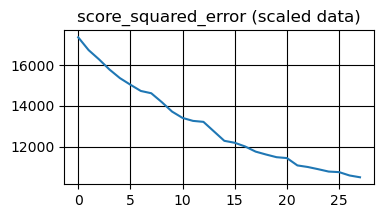

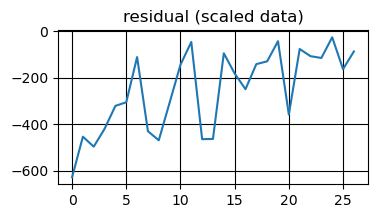

In [681]:
# Подготовка признаков (без userId)
X = clean_users_table.drop('userId', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# МЕТОД ЛОКТЯ НА МАСШТАБИРОВАННЫХ ДАННЫХ
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore", category = UserWarning, message = "KMeans is known to have a memory leak on Windows with MKL")

arr_score = []

# Локоть на масштабированных данных
for i in range(2, 30):
    kmeans = KMeans(n_clusters = i, random_state = 0, n_init = "auto", max_iter = 500).fit(X_scaled)
    score = kmeans.inertia_
    arr_score.append(score)

# График локтя
plt.figure(figsize = (4, 2))
plt.title('score_squared_error (scaled data)')
plt.plot(arr_score, '-')
plt.grid(True, color = 'k')
plt.show()

# Residual
residual_arr = []
for i in range(len(arr_score) - 1):
    res = arr_score[i+1] - arr_score[i]
    residual_arr.append(res)

plt.figure(figsize = (4, 2))
plt.title('residual (scaled data)')
plt.plot(residual_arr, '-')
plt.grid(True, color = 'k')
plt.show()

In [682]:
# Кластеризацая 11 кластеров
kmeans = KMeans(n_clusters=11, random_state=42, n_init=500)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем кластеры в таблицу пользователей
clean_users_table['cluster'] = clusters

In [683]:
# Статистика
print("Кластеры пользователей (масштабированные данные):")
for i in range(11):
    cluster_data = clean_users_table[clean_users_table['cluster'] == i]
    print(f"\nКластер {i}: {len(cluster_data)} пользователей")
    print(f"  Средняя оценка пользователя: {cluster_data['rating'].mean():.2f}")
    print(f"  Средний рейтинг фильмов: {cluster_data['vote_average'].mean():.2f}")
    print(f"  Средний бюджет: ${cluster_data['budget'].mean():,.0f}")

Кластеры пользователей (масштабированные данные):

Кластер 0: 110 пользователей
  Средняя оценка пользователя: 3.63
  Средний рейтинг фильмов: 7.03
  Средний бюджет: $25,906,380

Кластер 1: 119 пользователей
  Средняя оценка пользователя: 3.87
  Средний рейтинг фильмов: 6.29
  Средний бюджет: $13,767,978

Кластер 2: 18 пользователей
  Средняя оценка пользователя: 3.63
  Средний рейтинг фильмов: 6.63
  Средний бюджет: $19,513,582

Кластер 3: 46 пользователей
  Средняя оценка пользователя: 3.84
  Средний рейтинг фильмов: 6.65
  Средний бюджет: $33,459,688

Кластер 4: 250 пользователей
  Средняя оценка пользователя: 3.57
  Средний рейтинг фильмов: 6.64
  Средний бюджет: $19,180,626

Кластер 5: 4 пользователей
  Средняя оценка пользователя: 3.55
  Средний рейтинг фильмов: 6.30
  Средний бюджет: $22,644,267

Кластер 6: 1 пользователей
  Средняя оценка пользователя: 3.75
  Средний рейтинг фильмов: 5.62
  Средний бюджет: $13,235,120

Кластер 7: 36 пользователей
  Средняя оценка пользователя: 

In [684]:
# Анализ центроидов в масштабированном пространстве (спасибо 
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
feature_importance = (centroids.max() - centroids.min()).sort_values(ascending=False)

print("\nТОП-10 признаков после масштабирования:")
for i, (feature, importance) in enumerate(feature_importance.head(10).items(), 1):
    if 'genres_' in feature:
        print(f"{i}. {feature.replace('genres_', ''):20} влияние: {importance:.3f}σ")
    else:
        print(f"{i}. {feature:20} влияние: {importance:.3f}σ")


ТОП-10 признаков после масштабирования:
1. adult                влияние: 25.923σ
2. History              влияние: 11.196σ
3. Horror               влияние: 7.938σ
4. Foreign              влияние: 7.896σ
5. Family               влияние: 4.981σ
6. vote_average         влияние: 4.408σ
7. War                  влияние: 3.837σ
8. Animation            влияние: 3.409σ
9. production_countries влияние: 2.945σ
10. Action               влияние: 2.817σ


In [685]:
import numpy as np

# Выбираем случайного пользователя из кластера 0
cluster_0_users = clean_users_table[clean_users_table['cluster'] == 0]
random_user = cluster_0_users.sample(1)
random_user_id = random_user['userId'].iloc[0]
print(f"Случайный пользователь: {random_user_id}")

# Находим его вектор
all_user_ids = clean_users_table['userId'].tolist()
random_index = all_user_ids.index(random_user_id)
random_vector = X_scaled[random_index]

# Вычисляем расстояния до всех пользователей кластера 0
distances = []
cluster_indices = clean_users_table[clean_users_table['cluster'] == 0].index

for idx in cluster_indices:
    if idx == random_index:
        continue 
    
    distance = np.sqrt(np.sum((X_scaled[idx] - random_vector) ** 2))
    distances.append((clean_users_table.loc[idx, 'userId'], distance))

# Сортируем по расстоянию и берем 7 ближайших
distances.sort(key=lambda x: x[1])
nearest_7 = distances[:7]

# Выводим результат
print("\n7 ближайших пользователей:")
for user_id, dist in nearest_7:
    print(f"User {user_id}: расстояние {dist:.3f}")

Случайный пользователь: 302

7 ближайших пользователей:
User 548: расстояние 3.094
User 416: расстояние 3.254
User 7: расстояние 3.467
User 641: расстояние 3.485
User 39: расстояние 3.542
User 487: расстояние 3.592
User 254: расстояние 3.622


In [686]:
# userID = 92 (ближайшие - 92, 535, 19, 168, 254, 126, 548, 396)

In [687]:
df_films = df1[['id', 'title']].copy()
df_films['id'] = pd.to_numeric(df_films['id'], errors='coerce')
df_films = df_films.dropna(subset=['id'])

# Преобразуем сначала в float, затем в int (если есть 1.0, 2.0 и т.д.)
df_films['id'] = df_films['id'].astype('float').astype('int64')

# Удаляем строки, где не удалось преобразовать
df_films = df_films.dropna(subset=['id'])
df_films['id'] = df_films['id'].astype('int64')
df_films = df_films.rename(columns={'id': 'movieId'})

In [688]:
# Выбираем записи из df2, где userId входит в указанный список
users = [92, 535, 19, 168, 254, 126, 548, 396]
users_table = df2[df2['userId'].isin(users)]


In [689]:
users_films = users_table.merge(df_films, on='movieId', how='left')

In [690]:
# Создаем pivot таблицу: строки - фильмы, столбцы - пользователи, значения - оценки
pivot_table = users_films.pivot_table(
    index='title',
    columns='userId',
    values='rating'
)

# Добавляем количество оценок
pivot_table['num_ratings'] = pivot_table.notna().sum(axis=1)

# Оставляем фильмы с минимум 6 оценками
pivot_table_filtered = pivot_table[pivot_table['num_ratings'] >= 6].copy()

# Добавляем столбец со средней оценкой (только по имеющимся оценкам)
pivot_table_filtered['avg_rating'] = pivot_table_filtered[selected_userIds].mean(axis=1)

# Удаляем вспомогательную колонку num_ratings
pivot_table_filtered = pivot_table_filtered.drop('num_ratings', axis=1)

# Сортируем по средней оценке (по убыванию)
pivot_table_filtered = pivot_table_filtered.sort_values('avg_rating', ascending=False)

# Выводим таблицу
print("Таблица оценок фильмов (фильмы, оцененные минимум 6 пользователями):")
print(pivot_table_filtered)

Таблица оценок фильмов (фильмы, оцененные минимум 6 пользователями):
userId                                19   92  126  168  254  396  535  548  \
title                                                                         
The Million Dollar Hotel             4.0  5.0  4.0  5.0  4.0  NaN  4.0  5.0   
Solaris                              3.0  NaN  4.0  5.0  5.0  5.0  5.0  4.0   
Monsoon Wedding                      4.0  4.0  5.0  NaN  NaN  5.0  4.0  4.0   
Sissi                                4.0  4.0  4.0  4.0  4.0  3.0  4.0  5.0   
Terminator 3: Rise of the Machines   5.0  4.0  NaN  4.0  3.0  NaN  3.0  4.0   
The Poseidon Adventure               4.0  3.0  4.0  NaN  4.0  3.0  5.0  NaN   
Three Colors: Red                    3.0  5.0  NaN  3.0  NaN  3.0  4.0  5.0   
48 Hrs.                              3.0  3.0  5.0  4.0  3.0  5.0  NaN  3.0   
The Conversation                     4.0  3.0  4.0  3.0  3.0  4.0  5.0  NaN   
To Kill a Mockingbird                5.0  5.0  4.0  NaN  4.0  